# Introducción

| Columna      | Descripción breve                                                           | Aclaración / Interpretación adicional                                                                 |
|--------------|------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| Id           | Identificador único de cada usuario.                                        | No se repite entre filas. Cada registro corresponde a un usuario distinto.                            |
| send         | Número total de correos enviados al usuario.                                | Incluye todos los envíos, sin importar si fueron abiertos o no.                                       |
| bounce       | Número de correos rebotados (no entregados).                                | Recuento de correos que no llegaron por fallos como email inválido o bandeja llena.                   |
| open         | Número de veces que el usuario abrió correos.                               | Un usuario puede abrir un mismo correo varias veces. No implica clics.                                |
| click        | Número de veces que el usuario hizo clic en enlaces dentro de correos.      | Cuenta clics en cualquier enlace. Puede haber múltiples clics por correo o clics sin haber abierto.   |
| total        | Suma de send, bounce, open y click para ese usuario.                        | Puede no coincidir perfectamente en algunos registros; verificar consistencia antes de usar.           |
| comprador    | 1 si el usuario realizó al menos una compra, 0 si no compró nunca.          | Variable binaria. Puede usarse como objetivo en modelos de predicción (target).                       |
| hour         | Hora promedio del día en que el usuario interactuó -ya sea aperturas o clicks dentro de los mismos- con los correos.         | Valor entre 0 y 23, con decimales. Representa el promedio ponderado de las horas de interacción.      |
| day_of_week  | Día promedio de la semana de interacción -ya sea aperturas o clicks dentro de los mismos-.          | Valor continuo entre 0 y 6 -> 0 = lunes, 6 = domingo. Indica el día medio de actividad; por ejemplo, 2.5 ≈ martes/miércoles.    |

#EDA

In [19]:
# Importación de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# 🔹 Configuración global de pandas
# Con esta opción pandas mostrará TODAS las columnas de un DataFrame
# en lugar de truncar la vista con "..."
pd.set_option('display.max_columns', None)

# 🔹 Configuración de Google Colab (si trabajás allí)
from google.colab import data_table

# Por defecto Colab muestra los DataFrame como tablas interactivas.
# Esta línea desactiva ese formato y fuerza a que se muestren
# como texto plano (el estilo clásico de pandas).
data_table.disable_dataframe_formatter()


In [21]:
# Lee csv
df=pd.read_csv('/content/clustering_mailing.csv')

In [22]:
df.head(n=10)

,Id,send,bounce,open,click,Total,Comprador,hour,day_of_week
0,2044163,4,0,0,0,4,0,17.000000,3.500000
1,633731,1,0,0,0,1,0,21.000000,4.000000
2,1537126,4,0,0,0,4,0,17.000000,3.500000
3,1960135,3,0,0,0,3,0,15.333333,3.333333
4,1004992,8,0,1,0,10,1,18.222222,2.000000
5,1598931,2,0,0,0,2,1,17.500000,5.000000
6,2027234,1,1,0,0,2,0,23.000000,2.000000
7,34136,5,0,5,2,12,1,17.666667,2.000000
8,1440219,2,0,0,0,2,1,20.000000,1.500000
9,41994,7,0,7,2,16,0,9.500000,0.687500


In [23]:
# Pasar todas las columnas a minúscula
df.columns = [c.lower() for c in df.columns]

In [24]:
# Le cambio el nombre a la variable comprador para que esté en ingles al igual que el resto de las variables
df.rename(columns={"comprador": "buyer"}, inplace=True)


In [25]:
# Primeras observaciones

print('Tamaño:', df.shape)
print('Nulos:', df.isna().sum().sum())
print('Duplicados:',df.duplicated().sum())
print('Número de columnas categoricas:', len(df.select_dtypes(exclude='number').columns))
print('Número de columnas numéricas:', len(df.select_dtypes(include='number').columns))

Tamaño: (212292, 9)
Nulos: 0
Duplicados: 0
Número de columnas categoricas: 0
Número de columnas numéricas: 9


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212292 entries, 0 to 212291
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           212292 non-null  int64  
 1   send         212292 non-null  int64  
 2   bounce       212292 non-null  int64  
 3   open         212292 non-null  int64  
 4   click        212292 non-null  int64  
 5   total        212292 non-null  int64  
 6   buyer        212292 non-null  int64  
 7   hour         212292 non-null  float64
 8   day_of_week  212292 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 14.6 MB


In [27]:
# Estadísticos para todas las columnas (numéricas y no)
summary = df.describe(include='all')

# Solo columnas numéricas para rango y sesgo
df_num = df.select_dtypes(include='number')

# Rango
ranges = df_num.max() - df_num.min()
ranges_df = pd.DataFrame(ranges, columns=['ranges']).T

# Sesgo (Skewness)
skews = df_num.skew()
skews_df = pd.DataFrame(skews, columns=['skews']).T

# Concatenar con los estadísticos numéricos extendidos
numerical_stats = pd.concat([df_num.describe(), ranges_df, skews_df], sort=False)
numerical_stats

,id,send,bounce,open,click,total,buyer,hour,day_of_week
count,2.122920e+05,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000,212292.000000
mean,1.062074e+06,3.757801,0.264273,0.483819,0.072108,4.680077,0.616542,18.506052,2.467164
std,6.119871e+05,3.838834,0.665326,1.564734,0.607759,4.964009,0.486229,3.078170,1.208796
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5.336052e+05,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,17.000000,1.500000
50%,1.062491e+06,2.000000,0.000000,0.000000,0.000000,3.000000,1.000000,19.600000,2.333333
75%,1.592284e+06,5.000000,0.000000,0.000000,0.000000,6.000000,1.000000,20.666667,3.500000
max,2.122907e+06,167.000000,55.000000,174.000000,106.000000,390.000000,1.000000,23.000000,6.000000
ranges,2.122907e+06,166.000000,55.000000,174.000000,106.000000,389.000000,1.000000,23.000000,6.000000
skews,-1.918447e-03,3.372916,8.390671,16.921118,67.324691,7.690414,-0.479376,-1.495095,0.196647


## Análisis preliminar del conjunto de datos

Tras la primera inspección del DataFrame, se realizaron las siguientes observaciones:

- **Calidad de los datos:**  
  El dataset presenta un tamaño adecuado, sin valores nulos ni duplicados, lo que facilita su análisis.

- **Actualización de tipos de datos:**  
  - Convertí `day_of_week` de `float64` a `int64`, ya que se trata de una variable **categórica ordinal** que representa el día de la semana (0 = lunes, …, 6 = domingo).  
  - Convertí `hour` de `float64` a `int64`. Aunque originalmente podría interpretarse como un valor continuo (hora con decimales para minutos), asumí que corresponde a una **hora entera del día** (0–23) para simplificar el análisis.

- **Distribución y escala:**  
  Observé que las variables numéricas presentan rangos amplios y una alta concentración de datos en el rango intercuartílico superior (por encima del percentil 75%). Esta asimetría y la presencia de valores atípicos se tendrán en cuenta para definir la estrategia de escalado y normalización más adecuada para el modelo de clustering.


## Preparación y limpieza de datos

In [34]:
df_clean = df.copy()

In [35]:
df_clean

,id,send,bounce,open,click,total,buyer,hour,day_of_week
0,2044163,4,0,0,0,4,0,17.000000,3.500000
1,633731,1,0,0,0,1,0,21.000000,4.000000
2,1537126,4,0,0,0,4,0,17.000000,3.500000
3,1960135,3,0,0,0,3,0,15.333333,3.333333
4,1004992,8,0,1,0,10,1,18.222222,2.000000
...,...,...,...,...,...,...,...,...,...
212287,1996785,4,0,0,0,4,0,17.000000,3.500000
212288,1485221,1,1,0,0,2,0,19.000000,4.000000
212289,1521848,1,0,0,0,1,0,19.000000,4.000000
212290,2001602,5,0,0,0,5,1,20.200000,1.400000


In [36]:
# Convertir 'day_of_week' a un número del 1 al 7

df_clean['day_of_week'] = df_clean['day_of_week'].astype(int)

# Definir el número de días en una semana
total_dias = 7

# Aplicar las transformaciones de seno y coseno
df_clean['sin_day'] = np.sin(2 * np.pi * df_clean['day_of_week'] / total_dias)
df_clean['cos_day'] = np.cos(2 * np.pi * df_clean['day_of_week'] / total_dias)

# Eliminar la columna 'day_of_week' original
df_clean = df_clean.drop('day_of_week', axis=1)

# Las nuevas caracteristicas para clustering son 'sin_dia' y 'cos_dia'.

In [37]:
# Cambiamos el tipo de dato de hora a entero
df_clean['hour'] = df_clean['hour'].astype(int)

# Definimos el total de horas
total_hours = 24

# Aplica las transformaciones de seno y coseno
df_clean['sin_hour'] = np.sin(2 * np.pi * df_clean['hour'] / total_hours)
df_clean['cos_hour'] = np.cos(2 * np.pi * df_clean['hour'] / total_hours)

# Eliminar columna hour original
df_clean = df_clean.drop('hour', axis=1)

In [38]:
df_clean

,id,send,bounce,open,click,total,buyer,sin_day,cos_day,sin_hour,cos_hour
0,2044163,4,0,0,0,4,0,0.433884,-0.900969,-0.965926,-2.588190e-01
1,633731,1,0,0,0,1,0,-0.433884,-0.900969,-0.707107,7.071068e-01
2,1537126,4,0,0,0,4,0,0.433884,-0.900969,-0.965926,-2.588190e-01
3,1960135,3,0,0,0,3,0,0.433884,-0.900969,-0.707107,-7.071068e-01
4,1004992,8,0,1,0,10,1,0.974928,-0.222521,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...
212287,1996785,4,0,0,0,4,0,0.433884,-0.900969,-0.965926,-2.588190e-01
212288,1485221,1,1,0,0,2,0,-0.433884,-0.900969,-0.965926,2.588190e-01
212289,1521848,1,0,0,0,1,0,-0.433884,-0.900969,-0.965926,2.588190e-01
212290,2001602,5,0,0,0,5,1,0.781831,0.623490,-0.866025,5.000000e-01


## Verificación de inconsistencias

A continuación realizaré un analisis de posibles inconsistencias basandome en la naturaleza descriptiva de las variables y una logica acorde a este caso.

In [39]:
# Comprobacion de columna total

total_inconsistency = df_clean['send']+df_clean['bounce']+df_clean['open']+df_clean['click']==df_clean['total'] # Comprobamos que la suma de cada variable sea igual a total
total_inconsistency.value_counts()

,count
True,197009
False,15283


In [40]:
# Conteo absoluto
counts = total_inconsistency.value_counts()

# Porcentaje relativo
percentages = round(total_inconsistency.value_counts(normalize=True) * 100,2)

# Unimos en un DataFrame
result = pd.DataFrame({
    'count': counts,
    'percentage': percentages
})

print(result)


        count  percentage
True   197009        92.8
False   15283         7.2


Vemos que aproximadamente el 7.2% de los registros no cumple la condición de que el total sea la suma de los distintos eventos. Por esta razón, decidí eliminar la columna `total`, además de que resulta innecesaria para el análisis.

In [41]:
df_clean = df_clean.drop('total', axis=1)

Detectamos inconsistencias

In [42]:
# Diccionario de condiciones de inconsistencia
diccionario_de_inconsistencia = {
    "send_eq_bounce_and_interaction": (df_clean["send"] == df_clean["bounce"]) & ((df_clean["open"] + df_clean["click"]) > 0),
    "bounce_gt_send": df_clean["bounce"] > df_clean["send"],
    "send_zero_and_interaction": (df_clean["send"] == 0) & ((df_clean["open"] + df_clean["click"]) > 0),
    "negative_counts": (df_clean[["send","bounce","open","click"]] < 0).any(axis=1)
}

# Crear DataFrame temporal de flags (no modifica df original)
df_flags = pd.DataFrame(diccionario_de_inconsistencia).astype(int)

# Resumen de conteos por inconsistencia
print("Inconsistencias graves encontradas por tipo:")
print(df_flags.sum())

# Filtrar registros con al menos una inconsistencia
df_inconsistency = df_clean[df_flags.any(axis=1)].copy()

# Guardar a CSV
df_inconsistency.to_csv("inconsistencias_graves.csv", index=False)

print(f"\nTotal de registros con inconsistencias: {len(df_inconsistency)}")


Inconsistencias graves encontradas por tipo:
send_eq_bounce_and_interaction     6
bounce_gt_send                    11
send_zero_and_interaction          0
negative_counts                    0
dtype: int64

Total de registros con inconsistencias: 17


Durante la revisión de los datos, se identificaron ciertas inconsistencias relevantes en los eventos de la campaña:

- Casos en los que el total enviado (`send`) coincide con los rebotes (`bounce`) y, a pesar de ello, se registran aperturas o clics, lo cual es **incoherente con la lógica del envío**.  
- Situaciones en las que los rebotes (`bounce`) superan los envíos (`send`), imposibles desde el punto de vista operacional.  
- Registros donde existen aperturas o clics con `send` igual a cero, lo que evidencia una **contradicción en los datos**.  
- Valores negativos en cualquiera de los conteos (`send`, `bounce`, `open`, `click`), que carecen de validez.

La detección de estas inconsistencias permite **garantizar la integridad de los datos de interacción**, asegurando que los análisis posteriores reflejen patrones reales de comportamiento de los usuarios y no errores de registro.


In [43]:
# Eliminar estas filas del dataset para clustering
df_clustering = df_clean.drop(df_inconsistency.index).copy()

In [44]:
# Guardar el df como un csv en Colab
df_clustering.to_csv('/content/df_clustering.csv')

In [ ]:
df_clustering=pd.read_csv('/content/df_clustering.csv')

In [45]:
df_clustering

,id,send,bounce,open,click,buyer,sin_day,cos_day,sin_hour,cos_hour
0,2044163,4,0,0,0,0,0.433884,-0.900969,-0.965926,-2.588190e-01
1,633731,1,0,0,0,0,-0.433884,-0.900969,-0.707107,7.071068e-01
2,1537126,4,0,0,0,0,0.433884,-0.900969,-0.965926,-2.588190e-01
3,1960135,3,0,0,0,0,0.433884,-0.900969,-0.707107,-7.071068e-01
4,1004992,8,0,1,0,1,0.974928,-0.222521,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...
212287,1996785,4,0,0,0,0,0.433884,-0.900969,-0.965926,-2.588190e-01
212288,1485221,1,1,0,0,0,-0.433884,-0.900969,-0.965926,2.588190e-01
212289,1521848,1,0,0,0,0,-0.433884,-0.900969,-0.965926,2.588190e-01
212290,2001602,5,0,0,0,1,0.781831,0.623490,-0.866025,5.000000e-01


## Análisis gráfico de distribuciones

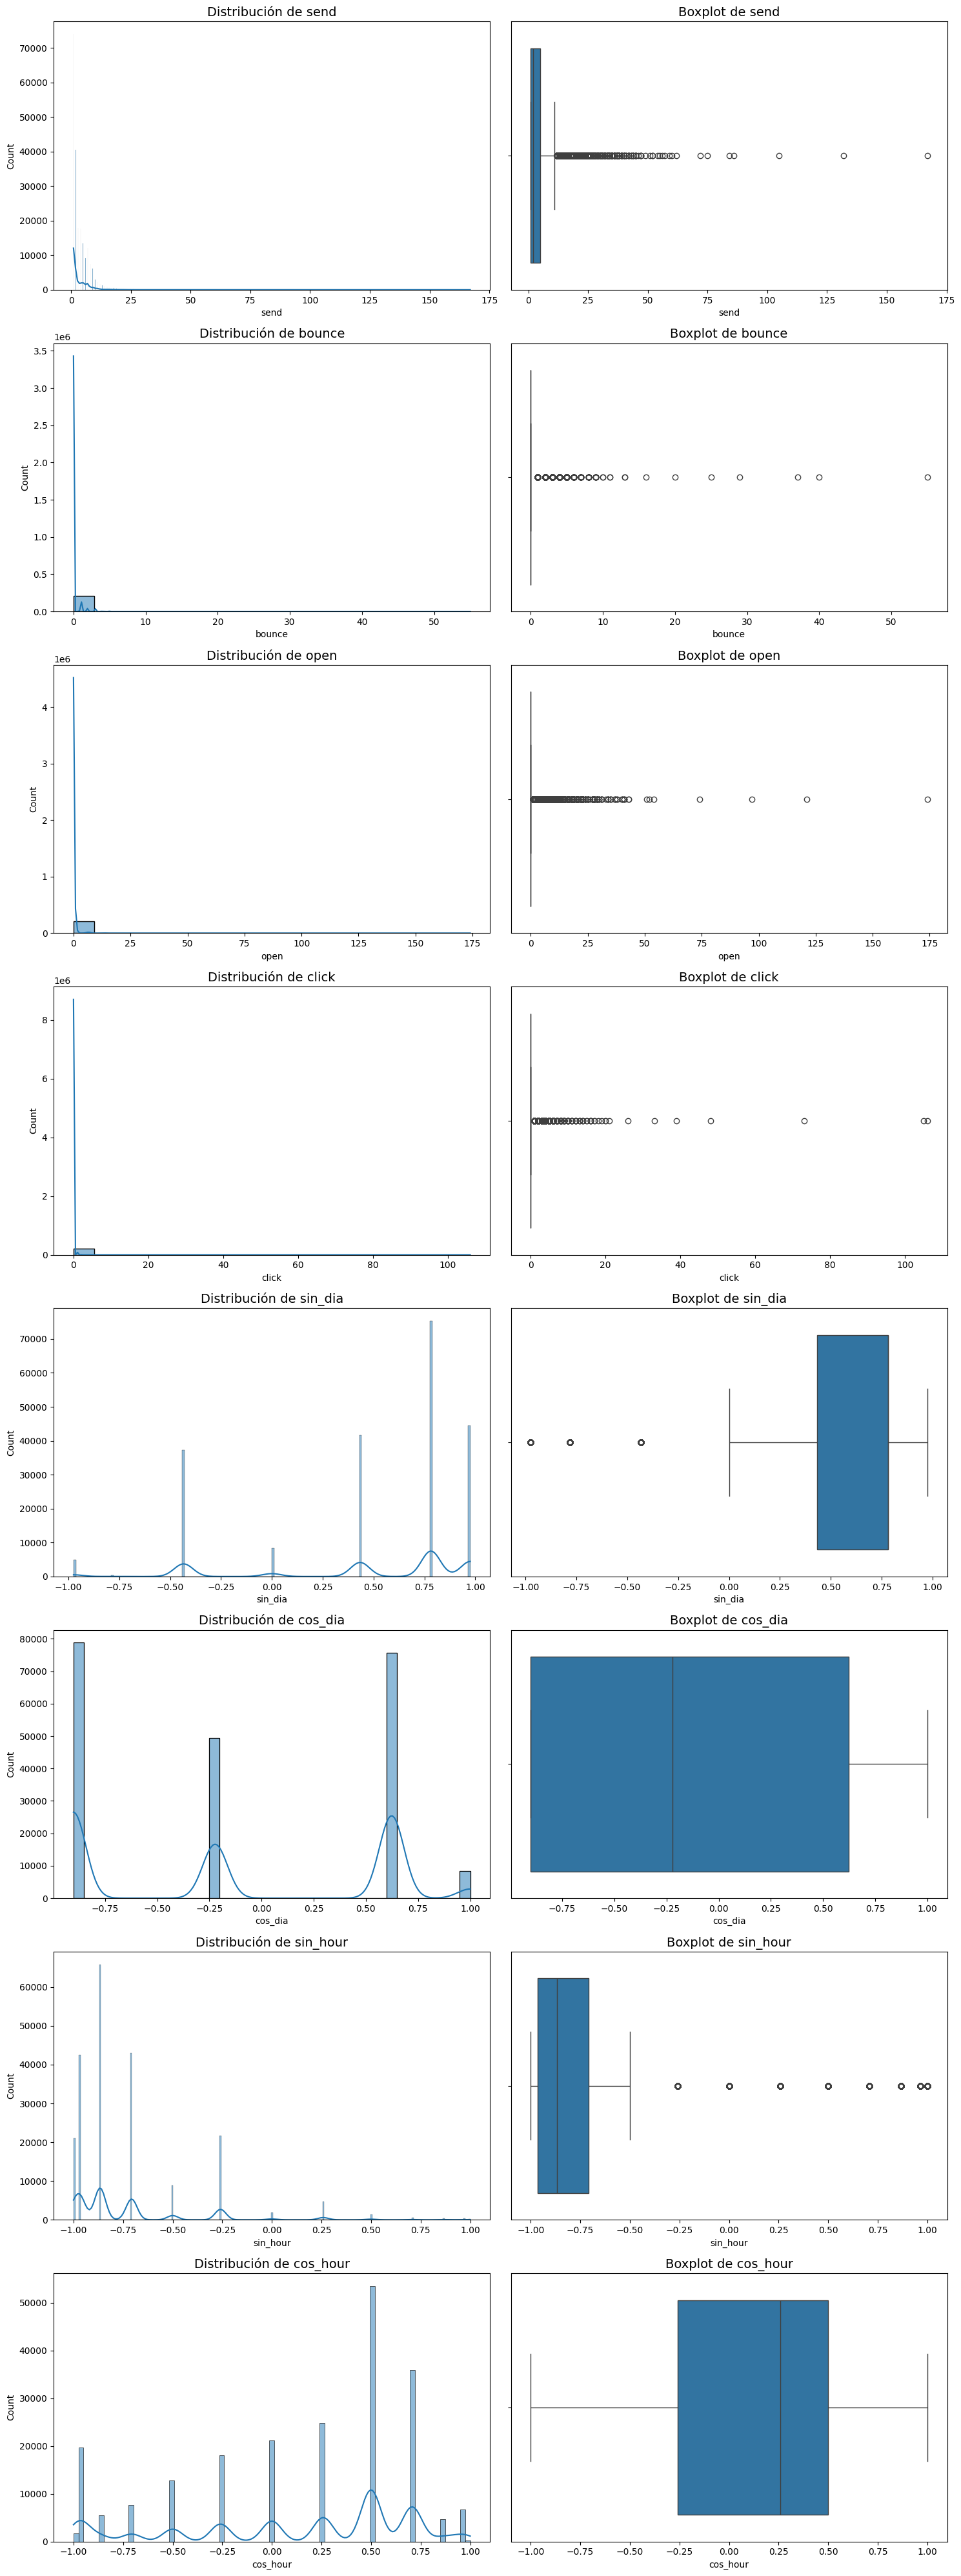

In [ ]:
from scipy.stats import skew, kurtosis

# Define las columnas numéricas
numerical_cols = ['send','bounce', 'open', 'click', 'sin_day', 'cos_day', 'sin_hour', 'cos_hour']

# Determina el número total de gráficos para la figura
num_plots = len(numerical_cols)
fig, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(15, 5 * num_plots))

# Itera sobre las columnas numéricas para crear histogramas y boxplots con etiquetas
for i, col in enumerate(numerical_cols):
    col_data = df_clustering[col].dropna()

    # --- Histograma ---
    sns.histplot(data=df_clustering, x=col, ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribución de {col}', fontsize=14)

    # Calcular métricas
    skew_val = skew(col_data)
    kurt_val = kurtosis(col_data)
    std_val = col_data.std()

    # Añadir etiquetas en el margen superior derecho
    axes[i, 0].text(0.98, 0.95, f'Sesgo: {skew_val:.2f}\nCurtosis: {kurt_val:.2f}\nDisp.: {std_val:.2f}',
                    transform=axes[i, 0].transAxes,
                    ha='right', va='top', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

    # --- Boxplot ---
    sns.boxplot(data=df_clustering, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col}', fontsize=14)

    # Calcular outliers usando IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = col_data[(col_data < Q1 - 1.5*IQR) | (col_data > Q3 + 1.5*IQR)]
    n_outliers = len(outliers)
    pct_outliers = 100 * n_outliers / len(col_data)

    # Añadir etiquetas en el margen superior derecho
    axes[i, 1].text(0.98, 0.95, f'Outliers: {n_outliers}\n% Outliers: {pct_outliers:.2f}%',
                    transform=axes[i, 1].transAxes,
                    ha='right', va='top', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

# Ajusta el diseño para evitar que el texto se superponga
plt.tight_layout()
plt.show()


Del análisis gráfico de las variables numéricas, se observa que `send`, `bounce` y `click` presentan distribuciones claramente **no normales**. Visualmente, estas métricas muestran una concentración en cero y una **cola larga**, más evidente al superponer la línea KDE en los histogramas. Este patrón es común en campañas de email, donde la mayoría de los usuarios tienen pocas interacciones, mientras que un pequeño grupo concentra un volumen elevado.

Los boxplots confirman esta observación: la gran cantidad de puntos aislados representan **outliers**, correspondientes a usuarios con niveles de interacción excepcionalmente altos. En conjunto, histogramas y boxplots permiten **entender la dispersión, la asimetría y la presencia de valores extremos**, información clave para decidir transformaciones o estrategias de escalado antes del clustering.

En cuanto a las variables `sin_day`, `cos_day`, `sin_hour` y `cos_hour`, estas se obtuvieron mediante una **transformación trigonométrica** de `day_of_week` y `hour`. Esta transformación ayuda a **normalizar parcialmente la distribución**, ajustar la escala y hacer que los gráficos sean más interpretables.


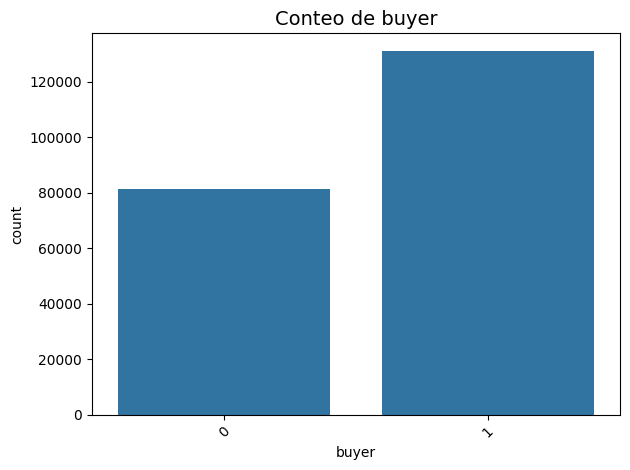

In [ ]:
sns.countplot(data=df_clustering, x='buyer')
plt.title('Conteo de buyer', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El gráfico de barras de la variable `buyer` muestra la **distribución de conversiones** en la campaña. Se observa que existe un **balance relativamente cercano entre compradores y no compradores**, aunque la proporción exacta dependerá del total de registros.  

Este tipo de visualización permite identificar rápidamente **la cantidad de usuarios que realizaron una compra frente a los que no**, lo cual es útil para entender el comportamiento general de la audiencia y para decisiones posteriores de segmentación o modelado.


# Ingenieria de Caracteristicas


En esta etapa se crean variables derivadas que permiten representar de manera más informativa el comportamiento de los usuarios frente a las campañas de email.  

- **`delivered`**: cantidad de correos efectivamente entregados al cliente, calculada como la diferencia entre los enviados y los rebotados.  
- **`open_rate`** y **`click_rate`**: proporciones transformadas con logaritmo que relacionan aperturas con entregas y clics con aperturas, respectivamente.  
  - Estas transformaciones permiten **suavizar distribuciones sesgadas**, manejar adecuadamente los valores extremos y los ceros, y a la vez conservar la relación relativa entre variables.  

Cabe destacar que, en entrenamientos previos, al utilizar únicamente las variables originales (`send`, `open`, `click`, `bounce`, etc.), el modelo de K-Means generaba clusters poco consistentes, llegando incluso a formar microgrupos con apenas un par de usuarios.  
La incorporación de estas nuevas variables ayuda a **normalizar el comportamiento relativo de los usuarios**, logrando clusters más homogéneos y con mayor valor interpretativo para la segmentación de marketing.


In [51]:
# Creamos la variable delivered para identificar la cantidad de emails que efectivamente recibio el cliente

df_clustering['delivered'] = (df_clustering['send'] - df_clustering['bounce']).clip(lower=0)

In [52]:
# Creamos open_rate y click_rate
df_clustering["open_rate"] = np.log1p(df_clustering["open"]) - np.log1p(df_clustering["delivered"])
df_clustering["click_rate"] = np.log1p(df_clustering["click"]) - np.log1p(df_clustering["open"])


In [ ]:
df_clustering.isna().sum()

,0
Unnamed: 0,0
id,0
send,0
bounce,0
open,0
click,0
buyer,0
sin_day,0
cos_day,0
sin_hour,0


# Preprocesamiento

A continuación, se realizo un análisis más sistemático de cada variable para identificar **sesgos, valores extremos y proporción de ceros**.  

Esta revisión permite decidir de manera fundamentada si aplicar **transformaciones (log1p) o escalado robusto**, y manejar de forma adecuada las variables trigonométricas o binarias. Así se prepara el dataset para que el clustering capture patrones reales sin verse afectado por distribuciones sesgadas o outliers.



In [ ]:
# Variables de interés
features = ["send","bounce", "open", "click","buyer","delivered","open_rate","click_rate",
            'sin_day','cos_day','sin_hour','cos_hour']

# Estadísticas básicas
stats = df_clustering[features].describe().T
stats["range"] = stats["max"] - stats["min"]
stats["skew"] = df_clustering[features].skew()
stats["pct_99"] = df_clustering[features].quantile(0.99)
stats["pct_01"] = df_clustering[features].quantile(0.01)

# Cálculo de outliers usando el método IQR
Q1 = df_clustering[features].quantile(0.25)
Q3 = df_clustering[features].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calcular porcentaje de outliers para cada variable
outliers_ratio = {}
for col in features:
    outliers_mask = (df_clustering[col] < lower_bound[col]) | (df_clustering[col] > upper_bound[col])
    outliers_ratio[col] = outliers_mask.mean() * 100

stats["outlier_ratio_iqr"] = outliers_ratio.values()

print("📊 Estadísticas y chequeo de sesgo / outliers:")
print(stats[["mean","std","min","25%","50%","75%","max","range","skew","outlier_ratio_iqr"]])

# Proporción de ceros
zeros = (df_clustering[features] == 0).sum() / len(df_clustering) * 100
print("\n⭕ Proporción de ceros por variable (%):")
print(zeros)

# Recomendación preliminar por variable
print("\n🔎 Recomendaciones de transformación:")
for col in features:
    skew_val = df_clustering[col].skew()
    zero_ratio = (df_clustering[col]==0).mean() * 100
    outlier_ratio_iqr = outliers_ratio[col]

    print(f"\nVariable: {col}")
    print(f" - Skew: {skew_val:.2f}")
    print(f" - Proporción de ceros: {zero_ratio:.2f}%")
    print(f" - Porcentaje de outliers (IQR): {outlier_ratio_iqr:.2f}%")

    # Variables trigonométricas
    if col in ["sin_day","cos_day","sin_hour","cos_hour"]:
        print("   ➝ Variable trigonométrica en [-1,1], no aplicar logaritmo. Opcional: escalar.")
        continue

    # Binaria
    if col == "buyer":
        print("   ➝ Variable binaria, no transformar.")
        continue

    # Variables continuas
    if skew_val > 1 or skew_val < -1:
        print("   ⚠ Distribución sesgada: considerar log1p o transformación similar")
    if zero_ratio > 50:
        print("   ⚠ Muchos ceros: log1p puede no ser útil → usar solo RobustScaler")
    if outlier_ratio_iqr > 5:
        print("   ⚠ Alto porcentaje de outliers: RobustScaler recomendado")

📊 Estadísticas y chequeo de sesgo / outliers:
                mean       std       min       25%       50%       75%  \
send        3.757993  3.838920  1.000000  1.000000  2.000000  5.000000   
bounce      0.264124  0.665069  0.000000  0.000000  0.000000  0.000000   
open        0.483802  1.564723  0.000000  0.000000  0.000000  0.000000   
click       0.072081  0.607644  0.000000  0.000000  0.000000  0.000000   
buyer       0.616578  0.486221  0.000000  0.000000  1.000000  1.000000   
delivered   3.493869  3.973871  0.000000  1.000000  2.000000  5.000000   
open_rate  -0.962788  0.793632 -4.465908 -1.609438 -1.098612  0.000000   
click_rate -0.186399  0.439081 -4.584967  0.000000  0.000000  0.000000   
sin_day     0.466045  0.540182 -0.974928  0.433884  0.781831  0.781831   
cos_day    -0.124626  0.689549 -0.900969 -0.900969 -0.222521  0.623490   
sin_hour   -0.736102  0.321848 -1.000000 -0.965926 -0.866025 -0.707107   
cos_hour    0.128898  0.581339 -1.000000 -0.258819  0.258819  0.50

## Resumen de preprocesamiento de variables para clustering

El análisis de sesgo, ceros y outliers permitió definir una estrategia diferenciada según el tipo de variable:

### 1. Variables de conteo
- **send**  
  - Pocos ceros, alta asimetría.  
  - Estrategia: aplicar `log1p` + `RobustScaler`.

- **bounce, open, click**  
  - Alto porcentaje de ceros (>70%).  
  - Estrategia: no usar logaritmo, solo `RobustScaler`.  

### 2. Variable binaria
- **buyer**  
  - Es binaria (0/1).  
  - Estrategia: solo **`RobustScaler`**.  
  nota: Decidi aplicarle escalado para suavizar el peso que le de el proceso de clustering.

### 3. Variables trigonométricas
- **sin_dia, cos_dia, sin_hour, cos_hour**  
  - Ya están normalizadas en [-1,1].  
  - Estrategia: no aplicar logaritmo. Acción: escalar con `RobustScaler` junto a las demás para homogeneizar magnitudes.

### 4. Outliers
- Presentes en varias variables de conteo e interacción.  
- Estrategia: el uso de `RobustScaler` asegura que no dominen el clustering.

---

✅ Este esquema balancea la reducción de asimetría y la protección contra outliers, manteniendo la interpretabilidad y coherencia de las variables circulares.


In [53]:
from sklearn.preprocessing import RobustScaler

In [54]:
# Log-transform en variables con sesgo alto y pocos ceros
for col in ['send','delivered']:
    df_clustering[f'{col}_log'] = np.log1p(df_clustering[col])

# Todas las columnas a escalar
columns_for_scaler = [
    'send_log',
    'bounce','open','click','delivered',
    'open_rate','click_rate',
    'sin_day','cos_day','sin_hour','cos_hour',
    'buyer'
]

# Escalado robusto
scaler = RobustScaler()
X_clustering = scaler.fit_transform(df_clustering[columns_for_scaler])

print("Matriz lista para clustering:", X_clustering.shape)



Matriz lista para clustering: (212275, 12)


In [55]:
X_clustering

array([[ 0.46497352,  0.        ,  0.        , ..., -0.38598559,
        -0.68216275, -1.        ],
       [-0.36907025,  0.        ,  0.        , ...,  0.61401441,
         0.59077028, -1.        ],
       [ 0.46497352,  0.        ,  0.        , ..., -0.38598559,
        -0.68216275, -1.        ],
       ...,
       [-0.36907025,  0.        ,  0.        , ..., -0.38598559,
         0.        , -1.        ],
       [ 0.63092975,  0.        ,  0.        , ...,  0.        ,
         0.31783725,  0.        ],
       [ 1.09590327,  0.        ,  9.        , ...,  1.41421356,
        -1.48236191,  0.        ]])

#Implementación de modelo de clustering: K_means

Se implementa un modelo de **K-Means** para segmentar a los usuarios según su comportamiento de interacción con los emails.  

K-Means se selecciona por su **eficiencia y facilidad de interpretación**, permitiendo identificar grupos de usuarios con patrones similares en métricas como envíos recibidos, aperturas, clics, tasas de interacción y tiempo de los eventos, lo que facilita la **toma de decisiones estratégicas y una segmentación técnicamente coherente y relevante**.



# Evaluación de *k*

En esta sección se evalúa el número óptimo de clusters (`k`) para el modelo K-Means.  

La evaluación se realizará considerando **la inercia (suma de distancias al centro del cluster)** y **el coeficiente de Silhouette**, métricas que permiten identificar un valor de `k` que capture patrones de comportamiento claros y consistentes entre los usuarios.


### Inercia

La inercia mide qué tan cerca están los puntos de sus centroides. Aunque disminuye a medida que se agregan clusters, el **criterio clave es identificar el “codo”**, es decir, el punto donde añadir un cluster adicional produce una **reducción marginal de la inercia**. Este punto indica un número de clusters que logra un buen equilibrio entre compactación y simplicidad en la segmentación.


In [ ]:
#Importamos libreria
from sklearn.cluster import KMeans

In [ ]:
K = np.arange(2,50)
K.shape

(48,)

In [ ]:
lista_inercias = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X_clustering)
    inercia = km.inertia_
    lista_inercias.append(inercia)

In [ ]:
for k_val, inercia_val in zip(K, lista_inercias):
    print(f"k={k_val}, inercia={inercia_val}")


k=2, inercia=1641258.8875260814
k=3, inercia=1326176.4088149117
k=4, inercia=1045141.2682510831
k=5, inercia=988531.8648892798
k=6, inercia=882013.0645714854
k=7, inercia=782226.7536989452
k=8, inercia=756721.3317370367
k=9, inercia=720298.2989501882
k=10, inercia=671141.2244478993
k=11, inercia=656562.4602628985
k=12, inercia=623655.9238147739
k=13, inercia=607088.8744286222
k=14, inercia=555448.869150474
k=15, inercia=536029.0810790812
k=16, inercia=525540.6126383423
k=17, inercia=507701.8192145716
k=18, inercia=466709.6241840689
k=19, inercia=432629.147984518
k=20, inercia=421937.77087225433
k=21, inercia=412169.900168322
k=22, inercia=402198.7715153096
k=23, inercia=395224.5241745595
k=24, inercia=386389.03230411274
k=25, inercia=373678.78225752886
k=26, inercia=362874.9430204602
k=27, inercia=358329.83815454115
k=28, inercia=346684.51811400295
k=29, inercia=340794.8487154718
k=30, inercia=334386.95297276694
k=31, inercia=330486.885165983
k=32, inercia=327734.0456543739
k=33, inerc

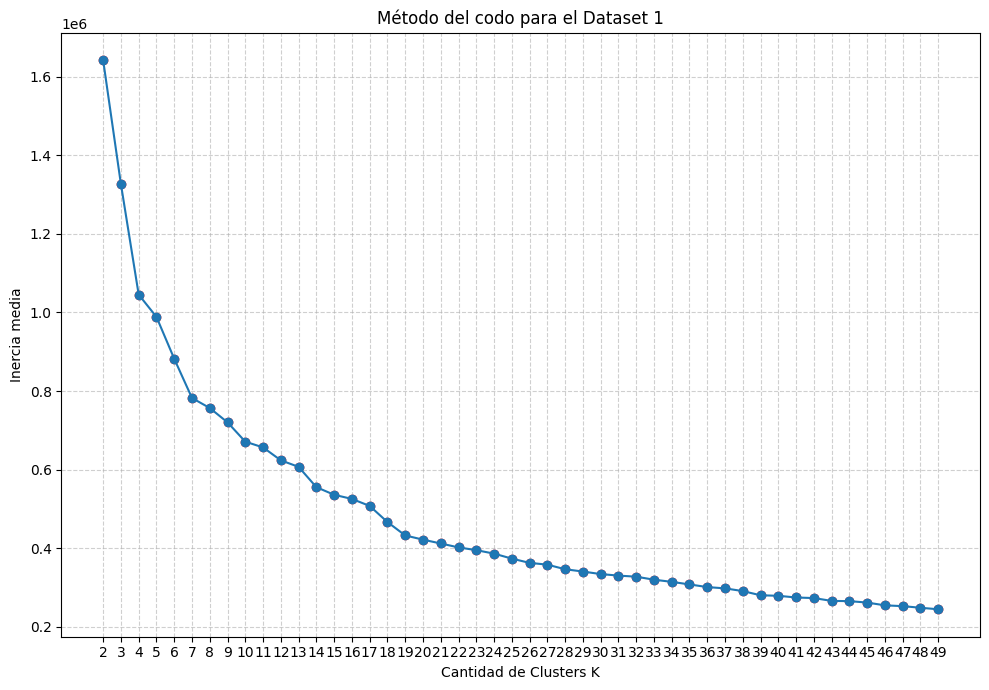

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(K, lista_inercias, marker='o')
plt.scatter(K, lista_inercias, c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset 1')

# Forzar que el eje X muestre solo enteros
plt.xticks(K)  # o range(min(K), max(K)+1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Silhouette

El coeficiente de Silhouette evalúa la **calidad del clustering** considerando tanto la separación entre clusters como la cohesión interna. Valores cercanos a 1 indican que los clusters están bien separados y los puntos dentro de cada cluster son similares entre sí, lo que refleja una **segmentación consistente y significativa**.


In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
lista_sil = []

for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=42).fit(X_clustering)

    etiquetas = km.labels_

    valor_medio_sil = silhouette_score(X_clustering, etiquetas)
    lista_sil.append(valor_medio_sil)

In [ ]:
lista_sil


[np.float64(0.3223491738857465),
 np.float64(0.3819891515632597),
 np.float64(0.4097727739242184),
 np.float64(0.4032021687761103),
 np.float64(0.3917653655786297),
 np.float64(0.32573547265080294),
 np.float64(0.2869059945875298),
 np.float64(0.3058987968149412),
 np.float64(0.3074004057580338),
 np.float64(0.31045760669962164),
 np.float64(0.3175870442141289),
 np.float64(0.31461949161889163),
 np.float64(0.3149522033247248),
 np.float64(0.32448122044311695),
 np.float64(0.30894551349177896),
 np.float64(0.3092865025989755),
 np.float64(0.32563583462734536),
 np.float64(0.34839733684654484)]

In [ ]:
print("K:", K)
print("Cantidad de elementos en K:", len(K))
print("lista_sil:", lista_sil)
print("Cantidad de elementos en lista_sil:", len(lista_sil))


K: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
Cantidad de elementos en K: 48
lista_sil: [np.float64(0.3223491738857465), np.float64(0.3819891515632597), np.float64(0.4097727739242184), np.float64(0.4032021687761103), np.float64(0.3917653655786297), np.float64(0.32573547265080294), np.float64(0.2869059945875298), np.float64(0.3058987968149412), np.float64(0.3074004057580338), np.float64(0.31045760669962164), np.float64(0.3175870442141289), np.float64(0.31461949161889163), np.float64(0.3149522033247248), np.float64(0.32448122044311695), np.float64(0.30894551349177896), np.float64(0.3092865025989755), np.float64(0.32563583462734536), np.float64(0.34839733684654484)]
Cantidad de elementos en lista_sil: 18


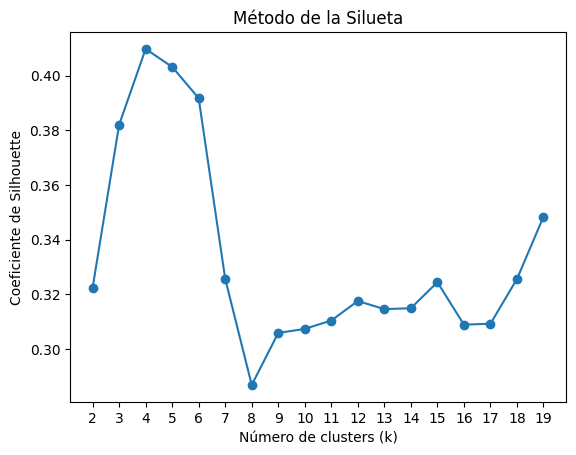

In [ ]:
import matplotlib.pyplot as plt

K_range = range(2, 20)
plt.plot(K_range, lista_sil, marker="o")
plt.xticks(K_range)  # <-- fuerza a que todos los ticks estén
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Método de la Silueta")
plt.show()


### Evaluación del número óptimo de clusters

La **inercia** mostró una disminución progresiva a medida que aumentaba *k*, con un descenso marcado hasta aproximadamente **k=5–7**, a partir del cual las mejoras se hacen más marginales. Esto ubica el “codo” de la curva en ese rango.  

Por otra parte, el **coeficiente silhouette** alcanzó su valor máximo en **k=3 (0.41)**, indicando que en este punto se logra la mayor cohesión interna y separación entre grupos. Sin embargo, a medida que se incrementa *k*, la métrica disminuye y se estabiliza en torno a **0.28–0.32**, lo cual sigue siendo aceptable para aplicaciones de negocio.  

Si bien desde un punto de vista puramente matemático podría recomendarse un valor bajo de *k* (como 3 o 4), en el contexto de **segmentación de clientes para email marketing** estos valores resultan demasiado generales. En este tipo de aplicación, es preferible sacrificar parte de la calidad de separación para obtener una **mayor granularidad en los segmentos**, lo que facilita la identificación de perfiles diferenciados y el diseño de estrategias personalizadas de comunicación.  

En este sentido, se seleccionó **k=5** como número de clusters: ofrece un buen equilibrio entre calidad técnica (silhouette razonable), simplicidad interpretativa y valor práctico, evitando tanto la excesiva generalización de *k* bajos como la complejidad y el ruido que pueden introducir valores más altos.  

# Entrenamiento

In [56]:
# -------------------------------------------
# Definir el modelo K-Means
# n_clusters=5: elegimos 5 clusters (puede ajustarse según evaluación previa)
# random_state=42: fija la semilla para resultados reproducibles
# -------------------------------------------
kmeans = KMeans(n_clusters=5, random_state=42)

# -------------------------------------------
# Ajustar el modelo a los datos escalados para clustering
# -------------------------------------------
kmeans.fit(X_clustering)

# -------------------------------------------
# Obtener las etiquetas asignadas a cada registro
# kmeans.labels_ devuelve un array con el cluster asignado a cada fila
# -------------------------------------------
etiquetas = kmeans.labels_

# -------------------------------------------
# Obtener los centroides de cada cluster
# Cada centro es un punto en el espacio de features que representa el "promedio" de cada cluster
# -------------------------------------------
centros = kmeans.cluster_centers_
centros


array([[-0.23382386,  1.26186423,  0.08119425,  0.0159665 , -0.44707054,
         0.6517814 , -0.04151438,  0.13110469,  0.23118367,  2.2571629 ,
        -0.86521395, -0.88020018],
       [-0.14678571,  0.2026705 ,  0.15790879,  0.02968365, -0.11197617,
         0.24196566, -0.07891834, -3.4455032 , -0.19387427,  0.47170327,
         0.27922742, -0.31131882],
       [ 0.43697705,  0.06624732,  0.32583219,  0.04943536,  0.68467528,
        -0.16103168, -0.16567513, -0.16937138,  0.13618974, -0.1147169 ,
        -0.09473259, -0.29818677],
       [-0.04135306,  0.12522329,  1.67274026,  0.34726688,  0.04403358,
         0.61042159, -0.69013988, -1.42738603, -0.10554067,  4.81852502,
        -1.21588615, -0.34387281],
       [ 1.04106946,  0.05324559,  6.51091834,  0.80990129,  2.11295992,
         0.47990708, -1.56168109, -0.02019857,  0.03930112,  0.64438423,
        -0.92204572, -0.31349088]])

In [57]:
#Incorporamos la columna cluster al data frame df_clustering
df_clustering["cluster"] = etiquetas

In [58]:
df_clustering

,id,send,bounce,open,click,buyer,sin_day,cos_day,sin_hour,cos_hour,delivered,open_rate,click_rate,send_log,delivered_log,cluster
0,2044163,4,0,0,0,0,0.433884,-0.900969,-0.965926,-2.588190e-01,4,-1.609438,0.000000,1.609438,1.609438,2
1,633731,1,0,0,0,0,-0.433884,-0.900969,-0.707107,7.071068e-01,1,-0.693147,0.000000,0.693147,0.693147,1
2,1537126,4,0,0,0,0,0.433884,-0.900969,-0.965926,-2.588190e-01,4,-1.609438,0.000000,1.609438,1.609438,2
3,1960135,3,0,0,0,0,0.433884,-0.900969,-0.707107,-7.071068e-01,3,-1.386294,0.000000,1.386294,1.386294,2
4,1004992,8,0,1,0,1,0.974928,-0.222521,-1.000000,-1.836970e-16,8,-1.504077,-0.693147,2.197225,2.197225,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212287,1996785,4,0,0,0,0,0.433884,-0.900969,-0.965926,-2.588190e-01,4,-1.609438,0.000000,1.609438,1.609438,2
212288,1485221,1,1,0,0,0,-0.433884,-0.900969,-0.965926,2.588190e-01,0,0.000000,0.000000,0.693147,0.000000,1
212289,1521848,1,0,0,0,0,-0.433884,-0.900969,-0.965926,2.588190e-01,1,-0.693147,0.000000,0.693147,0.693147,1
212290,2001602,5,0,0,0,1,0.781831,0.623490,-0.866025,5.000000e-01,5,-1.791759,0.000000,1.791759,1.791759,2


In [59]:
#Creamos el dataframe final solo con las columnas para el analisis de insight
df_final = df_clustering.drop(["send_log","delivered_log","open_rate","click_rate"], axis=1)

In [60]:
# Vemos la cantidad de clusters
df_final['cluster'].unique()

array([2, 1, 0, 4, 3], dtype=int32)

In [61]:
# Guardamos el df
df_final.to_csv('/content/df_final.csv')

### Visualización con reducción de dimensionalidad - UMAP

Para interpretar visualmente los clústeres encontrados, se aplicó **UMAP** (Uniform Manifold Approximation and Projection), una técnica no lineal de reducción de dimensionalidad que proyecta los datos en un espacio bidimensional.  

UMAP permite resaltar **estructuras locales** y separar clústeres que podrían no ser distinguibles en el espacio original de alta dimensión.  

Esta visualización facilita observar cómo los usuarios se agrupan según su comportamiento de interacción con los emails, mostrando la cohesión y separación de los clústeres identificados por K-Means.



/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.12/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


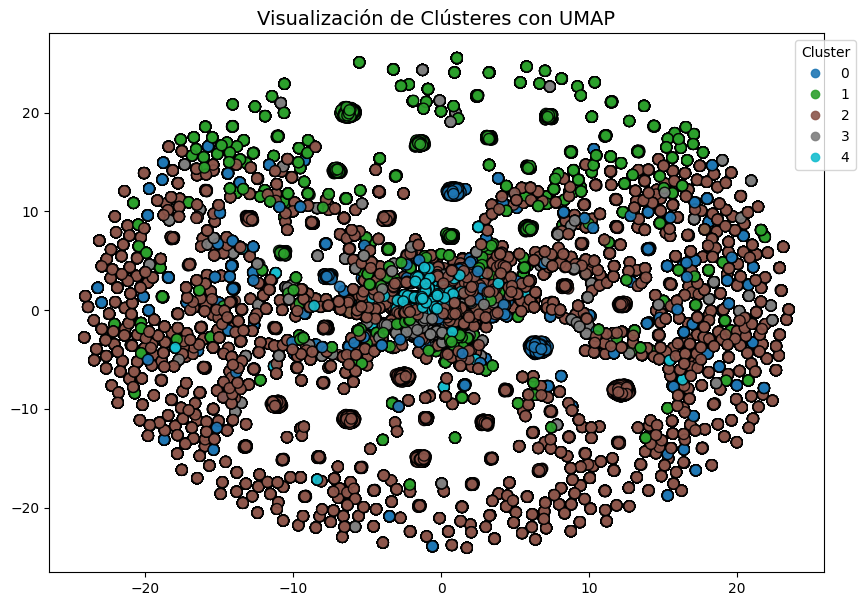

In [ ]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_clustering)

df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap["cluster"] = etiquetas

plt.figure(figsize=(10,7))
scatter = plt.scatter(
    df_umap["UMAP1"], df_umap["UMAP2"],
    c=df_umap["cluster"], cmap="tab10", s=60, alpha=0.9, edgecolor="k"
)
plt.title("Visualización de Clústeres con UMAP", fontsize=14)
plt.legend(*scatter.legend_elements(), title="Cluster", bbox_to_anchor=(1.05, 1))
plt.show()


### Caracterización de clusters

Una vez asignada la etiqueta de clúster a cada usuario, el siguiente paso consiste en **analizar las características distintivas de cada grupo**. Para ello, se construyeron un conjunto de **insights clave** que permiten interpretar los segmentos desde diferentes perspectivas:

- **Tamaño y composición**: cantidad de usuarios y proporción de compradores dentro de cada clúster.  
- **Interacciones con el email**: métricas de entrega, aperturas, clics y rebotes, junto con indicadores derivados como *open rate*, *CTR* y *CTOR*.  
- **Conversión**: porcentaje de compradores que llegaron a través de interacciones con los emails (apertura o clic).  
- **Engagement e intensidad**: indicadores compuestos que combinan tasas de interacción y conversión, reflejando el nivel de compromiso de cada grupo.  
- **Temporalidad**: reconstrucción de patrones de día y hora, identificando ventanas horarias y tipos de días (laborables vs. fin de semana) donde cada clúster presenta mayor actividad.  

Este análisis permite **caracterizar a los clústeres no solo por su comportamiento de interacción con las campañas de email, sino también por su contribución a la conversión y su dinámica temporal**, facilitando la definición de **estrategias de comunicación específicas para cada segmento**.


In [62]:
# Reconstruir día de la semana (0 = Lunes ... 6 = Domingo)
day_of_week = np.arctan2(df_final['sin_day'], df_final['cos_day'])
day_of_week = ((day_of_week + 2*np.pi) % (2*np.pi)) * 7 / (2*np.pi)
day_of_week = day_of_week.round().astype(int)

# Reconstruir hora del día (0 a 23)
hour = np.arctan2(df_final['sin_hour'], df_final['cos_hour'])
hour = ((hour + 2*np.pi) % (2*np.pi)) * 24 / (2*np.pi)
hour = hour.round().astype(int)

# Crear DataFrame auxiliar y asignar al original
df_final[['day_of_week', 'hour']] = pd.DataFrame({
    'day_of_week': day_of_week,
    'hour': hour
}, index=df_final.index)


In [63]:


# Flags por usuario (mutuamente excluyentes)

df_final['has_click'] = (df_final['click'] > 0).astype(int)
df_final['has_open'] = (df_final['open'] > 0).astype(int)
df_final['was_delivered'] = (df_final['delivered'] > 0).astype(int)
df_final['was_bounce'] = (df_final['bounce'] > 0).astype(int)

# Categorías de compradores excluyentes
df_final['buyer_from_click'] = ((df_final['buyer'] == 1) & (df_final['has_click'] == 1)).astype(int)
df_final['buyer_from_open_only'] = ((df_final['buyer'] == 1) &
                                    (df_final['has_click'] == 0) &
                                    (df_final['has_open'] == 1)).astype(int)
df_final['buyer_no_email_interaction'] = ((df_final['buyer'] == 1) &
                                          (df_final['has_open'] == 0) &
                                          (df_final['has_click'] == 0)).astype(int)


# Agrupación por cluster
agg = df_final.groupby('cluster').agg(
    cluster_size=('id', 'size'),
    total_buyers=('buyer', 'sum'),
    buyers_from_click=('buyer_from_click', 'sum'),
    buyers_from_open_only=('buyer_from_open_only', 'sum'),
    buyers_no_interaction=('buyer_no_email_interaction', 'sum'),
    total_sends=('send', 'sum'),
    users_delivered=('was_delivered', 'sum'),
    users_opened=('has_open', 'sum'),
    users_clicked=('has_click', 'sum'),
    users_bounced=('was_bounce', 'sum'),
    # Métricas de día y hora mejoradas
    best_day_mode=('day_of_week', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    pct_weekday=('day_of_week', lambda x: ((x >= 0) & (x <= 4)).mean() * 100),
    pct_weekend=('day_of_week', lambda x: ((x >= 5) & (x <= 6)).mean() * 100),
    hour_q1=('hour', lambda x: x.quantile(0.25)),
    hour_median=('hour', 'median'),
    hour_q3=('hour', lambda x: x.quantile(0.75)),
    hour_iqr=('hour', lambda x: x.quantile(0.75) - x.quantile(0.25))
).reset_index()

# Chequeo consistencia de compradores
agg['buyers_check_sum'] = (agg['buyers_from_click'] +
                          agg['buyers_from_open_only'] +
                          agg['buyers_no_interaction'])
agg['buyers_check_ok'] = (agg['buyers_check_sum'] == agg['total_buyers'])


# KPIs de marketing (en %)
agg['buyers_pct_cluster'] = np.where(
    agg['cluster_size'] > 0, agg['total_buyers'] / agg['cluster_size'] * 100, 0)

agg['buyers_click_pct_cluster'] = np.where(
    agg['cluster_size'] > 0, agg['buyers_from_click'] / agg['cluster_size'] * 100, 0)
agg['buyers_click_pct_buyers'] = np.where(
    agg['total_buyers'] > 0, agg['buyers_from_click'] / agg['total_buyers'] * 100, 0)

agg['open_rate_pct'] = np.where(
    agg['users_delivered'] > 0, agg['users_opened'] / agg['users_delivered'] * 100, 0)
agg['ctr_pct'] = np.where(
    agg['users_delivered'] > 0, agg['users_clicked'] / agg['users_delivered'] * 100, 0)
agg['ctor_pct'] = np.where(
    agg['users_opened'] > 0, agg['users_clicked'] / agg['users_opened'] * 100, 0)

agg['conversion_per_click_pct'] = np.where(
    agg['users_clicked'] > 0, agg['buyers_from_click'] / agg['users_clicked'] * 100, 0)

agg['buyers_opened'] = agg['buyers_from_click'] + agg['buyers_from_open_only']
agg['conversion_per_open_pct'] = np.where(
    agg['users_opened'] > 0, agg['buyers_opened'] / agg['users_opened'] * 100, 0)

agg['bounce_rate_pct'] = np.where(
    agg['total_sends'] > 0, agg['users_bounced'] / agg['total_sends'] * 100, 0)

agg['avg_sends_per_user'] = np.where(
    agg['cluster_size'] > 0, agg['total_sends'] / agg['cluster_size'], 0)
agg['avg_opens_per_user'] = np.where(
    agg['cluster_size'] > 0, agg['users_opened'] / agg['cluster_size'], 0)
agg['avg_clicks_per_user'] = np.where(
    agg['cluster_size'] > 0, agg['users_clicked'] / agg['cluster_size'], 0)

# Porcentaje de personas con al menos un correo entregado
agg['users_delivered_pct'] = np.where(
    agg['cluster_size'] > 0, agg['users_delivered'] / agg['cluster_size'] * 100, 0)

# Métricas compuestas
agg['engagement_score'] = (agg['open_rate_pct'] * 0.4 + agg['ctr_pct'] * 0.3 + agg['conversion_per_click_pct'] * 0.3)
agg['avg_interaction'] = np.where(
    agg['cluster_size'] > 0, (agg['users_opened'] + agg['users_clicked']) / agg['cluster_size'], 0)
agg['cluster_intensity'] = agg['buyers_pct_cluster'] * (agg['engagement_score'] / 100)

# === MÉTRICAS DERIVADAS ===

# Estimación de envíos totales a partir de promedio
agg['total_sends_est'] = (agg['avg_sends_per_user'] * agg['cluster_size']).round()

# Estimación de usuarios rebotados a partir de bounce_rate_pct
agg['users_bounced_est'] = np.round(agg['bounce_rate_pct'] / 100 * agg['total_sends_est'])

# Conteo de usuarios con entregas (derivado del delivered%)
agg['users_delivered_count'] = np.round(agg['users_delivered_pct'] / 100 * agg['cluster_size'])

# Distribución de compradores (en % sobre total de compradores)
agg['pct_buyers_from_click_of_buyers'] = np.where(
    agg['total_buyers'] > 0, agg['buyers_from_click'] / agg['total_buyers'] * 100, 0)

agg['pct_buyers_from_open_only_of_buyers'] = np.where(
    agg['total_buyers'] > 0, agg['buyers_from_open_only'] / agg['total_buyers'] * 100, 0)

agg['pct_buyers_no_interaction_of_buyers'] = np.where(
    agg['total_buyers'] > 0, agg['buyers_no_interaction'] / agg['total_buyers'] * 100, 0)

# Compradores por cada 1.000 usuarios del cluster (densidad)
agg['buyers_per_1000'] = np.where(
    agg['cluster_size'] > 0, agg['total_buyers'] / agg['cluster_size'] * 1000, 0)


# Día y hora óptimos

# Función para formatear horas decimales a formato HH:MM
def format_hour(decimal_hour):
    hours = int(decimal_hour)
    minutes = int((decimal_hour * 60) % 60)
    return f"{hours:02d}:{minutes:02d}"

# Determinar el tipo de día predominante
agg['best_day_type'] = np.where(agg['pct_weekday'] >= agg['pct_weekend'], 'Laborables', 'Fin de semana')

# Crear ventana horaria óptima basada en IQR
agg['best_hour_window'] = agg.apply(
    lambda row: f"{format_hour(max(0, row['hour_q1'] - 0.5 * row['hour_iqr']))} - {format_hour(min(24, row['hour_q3'] + 0.5 * row['hour_iqr']))}",
    axis=1
)

# Mapear el día modal a nombre
days_dict = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
agg['best_day_mode_name'] = agg['best_day_mode'].round().astype('Int64').map(days_dict)

# Output final

cols_out = [
    'cluster', 'cluster_size', 'total_buyers',
    'buyers_from_click', 'buyers_from_open_only', 'buyers_no_interaction',
    'buyers_pct_cluster', 'buyers_click_pct_buyers', 'buyers_click_pct_cluster',
    'pct_buyers_from_click_of_buyers', 'pct_buyers_from_open_only_of_buyers',
    'pct_buyers_no_interaction_of_buyers', 'buyers_per_1000',
    'users_delivered_pct', 'users_delivered_count',
    'open_rate_pct', 'ctr_pct', 'ctor_pct',
    'conversion_per_click_pct', 'conversion_per_open_pct', 'bounce_rate_pct',
    'users_bounced_est', 'total_sends_est',
    'avg_sends_per_user', 'avg_opens_per_user', 'avg_clicks_per_user',
    'engagement_score', 'avg_interaction', 'cluster_intensity',
    'users_opened', 'users_clicked',
    'best_day_mode_name', 'best_day_type', 'pct_weekday', 'pct_weekend',
    'best_hour_window', 'hour_q1', 'hour_median', 'hour_q3', 'hour_iqr'
]


agg_out = agg[cols_out]
agg_out.to_csv('/content/agg_out_enhanced.csv', index=False)
agg_out


,cluster,cluster_size,total_buyers,buyers_from_click,buyers_from_open_only,buyers_no_interaction,buyers_pct_cluster,buyers_click_pct_buyers,buyers_click_pct_cluster,pct_buyers_from_click_of_buyers,pct_buyers_from_open_only_of_buyers,pct_buyers_no_interaction_of_buyers,buyers_per_1000,users_delivered_pct,users_delivered_count,open_rate_pct,ctr_pct,ctor_pct,conversion_per_click_pct,conversion_per_open_pct,bounce_rate_pct,users_bounced_est,total_sends_est,avg_sends_per_user,avg_opens_per_user,avg_clicks_per_user,engagement_score,avg_interaction,cluster_intensity,users_opened,users_clicked,best_day_mode_name,best_day_type,pct_weekday,pct_weekend,best_hour_window,hour_q1,hour_median,hour_q3,hour_iqr
0,0,29374,3519,178,1128,2213,11.979982,5.058255,0.605978,5.058255,32.054561,62.887184,119.799823,9.164567,2692.0,66.641902,9.955423,14.938685,66.417910,72.798216,62.538986,27070.0,43285.0,1.473582,0.061074,0.009124,49.568761,0.070198,5.938329,1794,268,Martes,Laborables,100.000000,0.000000,09:00 - 24:00,13.0,13.0,21.0,8.0
1,1,48680,33525,677,3809,29039,68.868118,2.019389,1.390715,2.019389,11.361670,86.618941,688.681183,81.686524,39765.0,13.861436,2.104866,15.185051,80.884110,81.386067,10.733769,9169.0,85422.0,1.754766,0.113229,0.017194,30.441267,0.130423,20.964328,5512,837,Viernes,Laborables,89.864421,10.135579,19:30 - 21:30,20.0,21.0,21.0,1.0
2,2,121938,85578,2863,17963,64752,70.181568,3.345486,2.347915,3.345486,20.990208,75.664306,701.815677,97.419180,118791.0,22.818227,3.134918,13.738656,76.879699,76.831698,0.905428,5305.0,585911.0,4.804991,0.222293,0.030540,33.131676,0.252833,23.252330,27106,3724,Martes,Laborables,100.000000,0.000000,17:00 - 21:00,18.0,19.0,20.0,2.0
3,3,5598,3673,717,2850,106,65.612719,19.520828,12.808146,19.520828,77.593248,2.885924,656.127188,90.139335,5046.0,92.251288,18.212446,19.742213,78.019587,76.627282,4.734922,610.0,12883.0,2.301358,0.831547,0.164166,65.770125,0.995713,43.153567,4655,919,Jueves,Laborables,93.319043,6.680957,07:30 - 13:30,9.0,10.0,12.0,3.0
4,4,6685,4589,1429,3160,0,68.646223,31.139682,21.376215,31.139682,68.860318,0.000000,686.462229,100.000000,6685.0,99.985041,31.952132,31.956912,66.900749,68.656493,0.192234,135.0,70227.0,10.505161,0.999850,0.319521,69.649881,1.319372,47.812012,6684,2136,Miércoles,Laborables,99.895288,0.104712,12:30 - 18:30,14.0,16.0,17.0,3.0


# Caracterización de clusters


## Cluster 0 — “Alta falla / Entregabilidad baja” *(Candidate for cleaning)*

- **Tamaño**: 29.374 usuarios  
- **Compradores**: 3.519 (≈ 11,98% del cluster)  
  - Desde click: 178 (≈ 5,06% de los compradores)  
  - Desde open-only: 1.128 (≈ 32,05%)  
  - Sin interacción (otros canales): 2.213 (≈ 62,89%)  

### Entregabilidad & rebotes (estimados)
- Usuarios con ≥1 entrega: 2.692 (≈ 9,16% del cluster)  
- Envíos totales estimados: 43.285  
- Usuarios rebotados estimados: 27.070 (≈ 62,54% de los envíos)  

**Conclusión**: entregabilidad extremadamente baja y tasa de rebote alarmante → lista con muchas direcciones inválidas / bloqueos.

### Interacción
- Aperturas: 1.794 → **open rate ≈ 66,64%**  
- Clics: 268 → **CTR ≈ 9,95%**  
- CTOR ≈ 14,94%  

### Conversiones
- Conv. por click ≈ **66,4%**  
- Conv. por open ≈ **72,8%**  

### Frecuencia / timing
- Avg sends / usuario: 1,47  
- Avg opens / usuario: 0,06  
- Día modal: **Martes**  
- Ventana óptima: **09:00–24:00** (mediana 13:00)  

### Problemas detectados
- Entrega muy baja y bounce rate altísimo → riesgo de reputación.  
- Gran proporción de compradores que no interactúan con email (62,9%).  

### Recomendaciones
- Parar envíos masivos a este cluster hasta validación.  
- Limpieza de emails (third-party verification).  
- Campaña de reconfirmación controlada.  
- Revisar configuración técnica (SPF/DKIM/DMARC).  
- Corregir pipeline de ingestión (doble opt-in).  

---

## Cluster 1 — “Compradores silenciosos (otros canales)”

- **Tamaño**: 48.680  
- **Compradores**: 33.525 (≈ 68,87%)  
  - Desde click: 677 (≈ 2,02%)  
  - Desde open-only: 3.809 (≈ 11,36%)  
  - Sin interacción: 29.039 (≈ 86,62%)  

### Entregabilidad
- Entregados: 39.765 (≈ 81,69%)  
- Envíos estimados: 85.422  
- Rebotados estimados: 9.169 (≈ 10,73%)  

### Interacción
- Aperturas: 5.512 → **open rate ≈ 13,87%**  
- Clics: 837 → **CTR ≈ 2,11%**  
- CTOR ≈ 15,19%  

### Conversiones
- Conv. por click ≈ **80–81%** (alta eficiencia, bajo volumen).  

### Timing
- Día modal: **Viernes**  
- Ventana estrecha: **19:30–21:30**  

### Interpretación
- Compran por otros canales, email no es su activador principal.  

### Acciones recomendadas
- Atribución multicanal (CRM, cross-reference).  
- Mantener emails de marca y transaccionales, reducir promociones masivas.  
- Micro-tests para identificar subgrupos engaged.  
- Potenciar inversión en los canales donde realmente convierten.  

---

## Cluster 2 — “Gran masa poco atenta (volumen)”

- **Tamaño**: 121.938 (el mayor cluster)  
- **Compradores**: 85.578 (≈ 70,18%)  
  - Desde click: 2.863 (≈ 3,35%)  
  - Desde open-only: 17.963 (≈ 20,99%)  
  - Sin interacción: 64.752 (≈ 75,66%)  

### Entregabilidad
- Entregados: 118.791 (≈ 97,42%)  
- Envíos estimados: 585.911  
- Rebotados estimados: 5.305 (≈ 0,91%)  

### Interacción
- Aperturas: 27.106 → **open rate ≈ 22,82%**  
- Clics: 3.724 → **CTR ≈ 3,14%**  
- CTOR ≈ 13,74%  

### Conversiones
- Conv. por click ≈ **76,9%**  
- Conv. por open ≈ **76,8%**  

### Timing
- Día modal: **Martes**  
- Horario: **17:00–21:00**  

### Estrategia recomendada
- Mantener envíos periódicos (buen delivery).  
- Subsegmentación por engagement (frecuentes, clickeadores, inactivos).  
- Para inactivos: campañas cross-channel o incentivos distintos.  
- Optimizar frecuencia para reducir ruido y coste.  

---

## Cluster 3 — “Engagers matutinos (alto valor por email)”

- **Tamaño**: 5.598  
- **Compradores**: 3.673 (≈ 65,61%)  
  - Desde click: 717 (≈ 19,52%)  
  - Desde open-only: 2.850 (≈ 77,59%)  
  - Sin interacción: 106 (≈ 2,89%)  

### Entregabilidad
- Entregados: 5.046 (≈ 90,14%)  
- Envíos estimados: 12.883  
- Rebotados estimados: 610 (≈ 4,73%)  

### Interacción
- Aperturas: 4.655 → **open rate ≈ 92,3%**  
- Clics: 919 → **CTR ≈ 18,2%**  
- CTOR ≈ 19,8%  

### Conversiones
- Conv. por click ≈ **78%**  
- Conv. por open ≈ **76,6%**  

### Timing
- Mejor día: **Jueves**  
- Ventana óptima: **07:30–13:30**  

### Recomendaciones
- Priorizar este cluster en campañas email.  
- Envíos de alto impacto en la mañana.  
- Tests A/B de creativos y CTA.  
- Estrategias de fidelización y VIP.  

---

## Cluster 4 — “Elite hiper-engaged (VIP email)”

- **Tamaño**: 6.685  
- **Compradores**: 4.589 (≈ 68,65%)  
  - Desde click: 1.429 (≈ 31,14%)  
  - Desde open-only: 3.160 (≈ 68,86%)  
  - Sin interacción: 0 (0%)  

### Entregabilidad
- Entregados: 6.685 (100%)  
- Envíos estimados: 70.227  
- Rebotados estimados: 135 (≈ 0,19%)  

### Interacción
- Aperturas: 6.684 → **open rate ≈ 100%**  
- Clics: 2.136 → **CTR ≈ 31,96%**  
- CTOR ≈ 31,96%  

### Conversiones
- Conv. por click ≈ **66,9%**  
- Conv. por open ≈ **68,7%**  

### Frecuencia
- Avg sends / usuario ≈ 10,5 (toleran volumen alto).  

### Recomendaciones
- Tratarlos como **VIP** (early access, bundles, ofertas premium).  
- Medir y maximizar LTV.  
- Mantener higiene y configuración técnica impecable.  


# Insight Generales

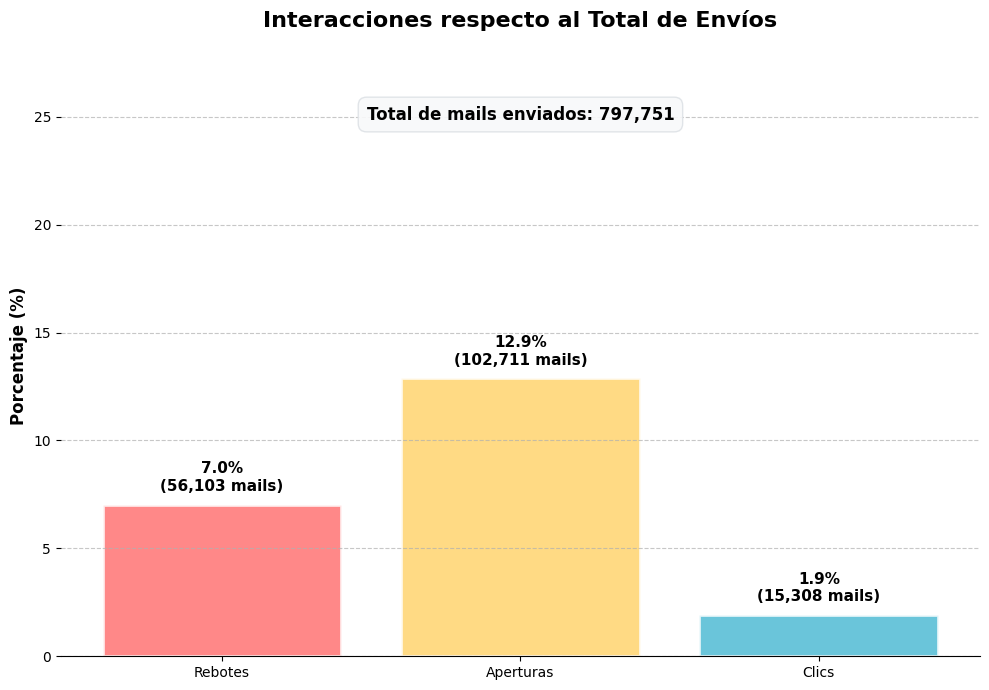

In [47]:
# Calcular totales
total_send = df['send'].sum()
bounce_total = df['bounce'].sum()
open_total = df['open'].sum()
click_total = df['click'].sum()

# Calcular porcentajes respecto a send
bounce_percentage = (bounce_total / total_send) * 100
open_percentage = (open_total / total_send) * 100
click_percentage = (click_total / total_send) * 100

# Preparar datos
labels = ['Rebotes', 'Aperturas', 'Clics']
percentages = [bounce_percentage, open_percentage, click_percentage]
totals = [bounce_total, open_total, click_total]
colors = ['#FF6B6B', '#FFD166', '#45B7D1']  # Colores modernos y armoniosos

# Crear gráfico de barras
plt.figure(figsize=(10, 7))
bars = plt.bar(labels, percentages, color=colors, alpha=0.8, edgecolor='white', linewidth=2)

# Agregar texto con porcentaje y valor absoluto en cada barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    total_val = totals[i]
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
             f'{height:.1f}%\n({int(total_val):,} mails)',
             ha='center', va='bottom', size=11, weight='bold')

# Título, ejes y total
plt.title('Interacciones respecto al Total de Envíos', size=16, weight='bold', pad=20)
plt.ylabel('Porcentaje (%)', size=12, weight='bold')
plt.ylim(0, max(percentages) + 15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar total general arriba del gráfico
plt.text(1, max(percentages) + 12,
         f'Total de mails enviados: {int(total_send):,}',
         ha='center', size=12, weight='bold',
         bbox=dict(boxstyle="round,pad=0.5", fc="#F8F9FA", ec="#DEE2E6", alpha=0.9))

# Quitar bordes innecesarios
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

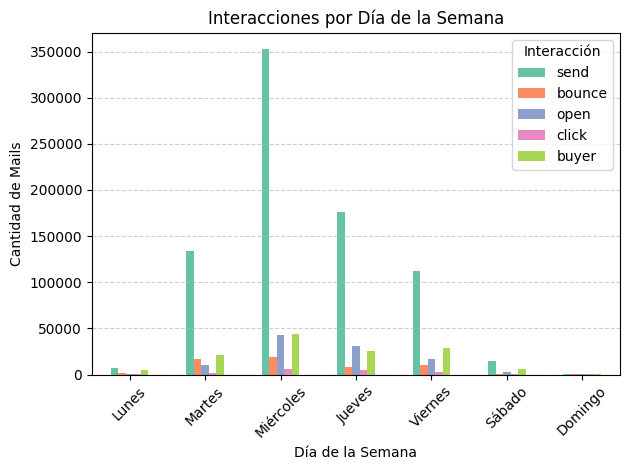

In [48]:
# 1. Limpiar valores de 'day_of_week' (reemplazar coma por punto y convertir a float)
df['day_of_week'] = df['day_of_week'].astype(str).str.replace(',', '.', regex=False)
df['day_of_week'] = df['day_of_week'].astype(float)

# 2. Redondear y agrupar por día
df['day_group'] = df['day_of_week'].round().astype(int)

# 3. Calcular suma de interacciones por día
day_interaction_summary = df.groupby('day_group')[['send', 'bounce', 'open', 'click', 'buyer']].sum().reset_index()

# 4. Mapeo opcional de nombres de días si querés hacerlo más visual
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
day_interaction_summary['day_name'] = day_interaction_summary['day_group'].map(dict(zip(range(7), dias)))

# 5. Gráfico de barras de interacciones por día
plt.figure(figsize=(12, 6))
sns.set_palette("Set2")
day_interaction_summary.set_index('day_name')[['send', 'bounce', 'open', 'click', 'buyer']].plot(kind='bar', stacked=False)

plt.title('Interacciones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Mails')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Interacción')
plt.show()

/tmp/ipython-input-279383694.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_interaction_summary = df_graf.groupby('hour_group_label')[['send', 'bounce', 'open', 'click']].sum().reset_index()


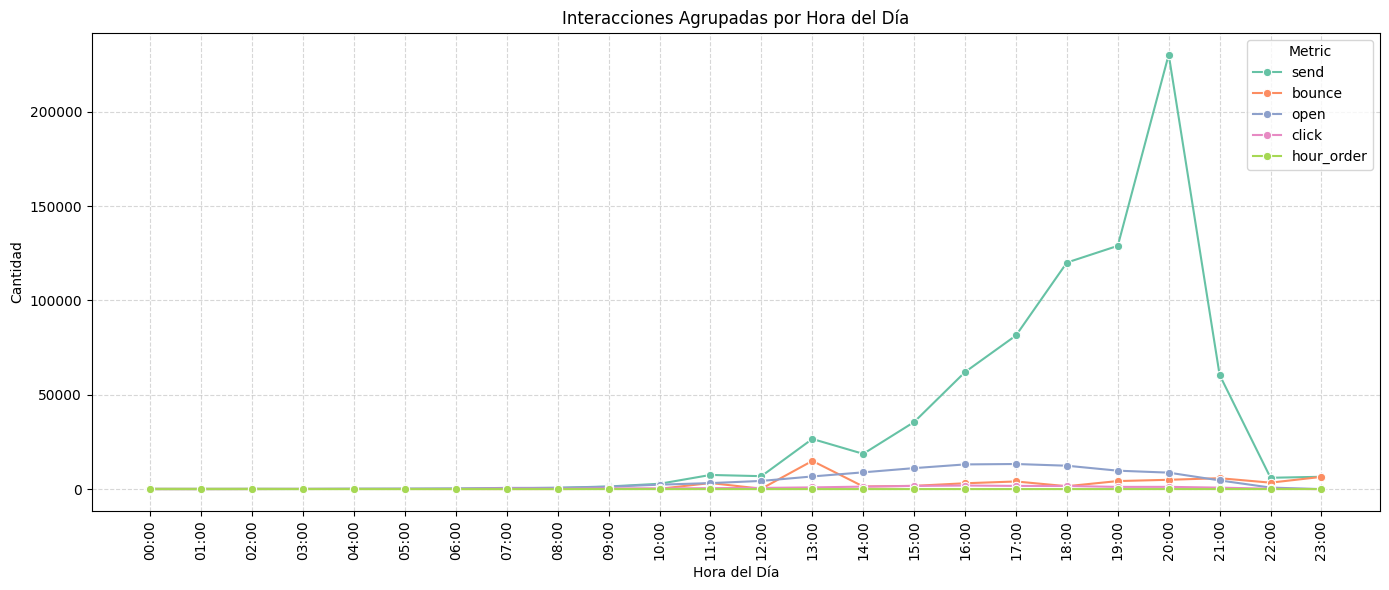

In [50]:
# 1. Reemplazar comas por puntos y convertir a float
df_graf = df.copy()

df_graf['hour'] = df['hour'].astype(str).str.replace(',', '.', regex=False)
df_graf['hour'] = df['hour'].astype(float)

# 2. Agrupar por rango horario (bins de 1 hora)
df_graf['hour_group'] = pd.cut(df_graf['hour'], bins=range(0, 25), right=False)

# 3. Crear etiquetas como "00:00", "01:00", etc.
labels = [f'{h:02d}:00' for h in range(24)]
df_graf['hour_group_label'] = df_graf['hour_group'].apply(lambda x: labels[int(x.left)] if pd.notnull(x) else 'Desconocido')

# 4. Sumar interacciones por grupo horario
hour_interaction_summary = df_graf.groupby('hour_group_label')[['send', 'bounce', 'open', 'click']].sum().reset_index()

# 5. Reordenar según hora
hour_interaction_summary['hour_order'] = hour_interaction_summary['hour_group_label'].str.extract(r'(\d+)', expand=False).astype(int)
hour_interaction_summary = hour_interaction_summary.sort_values('hour_order')

# 🔹 Formato largo para graficar
hour_interaction_summary_melted = hour_interaction_summary.melt(
    id_vars='hour_group_label', var_name='Metric', value_name='Count')

# 🔹 Gráfico de líneas
plt.figure(figsize=(14, 6))
sns.lineplot(data=hour_interaction_summary_melted, x='hour_group_label', y='Count', hue='Metric', marker='o')
plt.title('Interacciones Agrupadas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-668042743.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=count_ids, x='cluster', y='count_unique_Id',


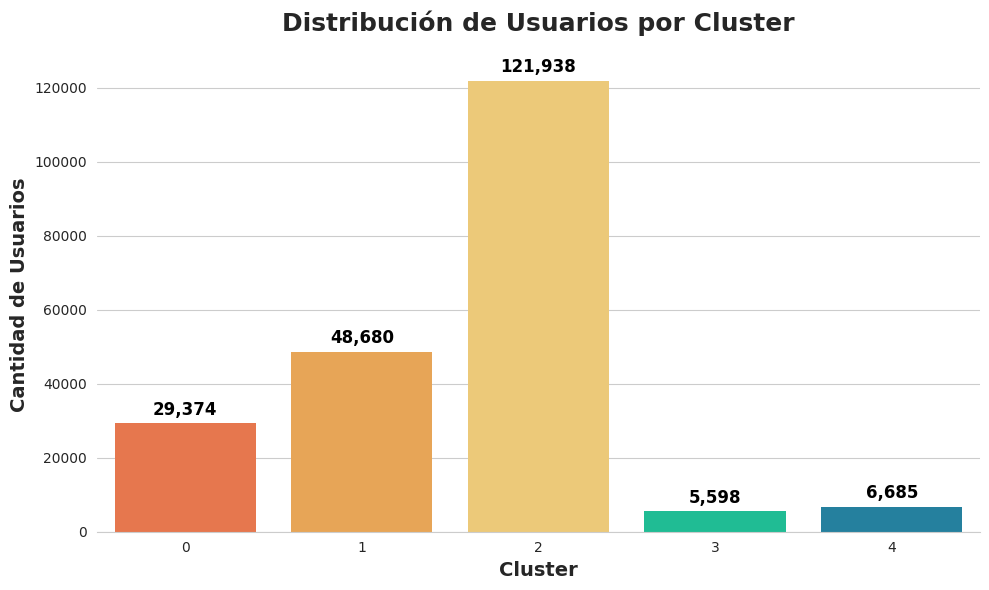

In [64]:
# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['font.family'] = ['sans-serif']

# Para contar los Ids únicos por cluster
count_ids = df_final.groupby('cluster')['id'].nunique().reset_index()
count_ids.columns = ['cluster', 'count_unique_Id']

# Crear figura
plt.figure(figsize=(10, 6))

# Paleta de colores cálidos y sólidos (sin transparencia)
warm_solid_palette = ['#FF6B35', '#FFA73F', '#FFD166', '#06D6A0', '#118AB2']

# Crear gráfico con Seaborn
ax = sns.barplot(data=count_ids, x='cluster', y='count_unique_Id',
                 palette=warm_solid_palette,
                 alpha=1.0, edgecolor=None, linewidth=0)  # Sin bordes

# Personalizar títulos y etiquetas
plt.title('Distribución de Usuarios por Cluster',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Usuarios', fontsize=14, fontweight='bold')

# Agregar valores en las barras
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(count_ids['count_unique_Id'])*0.01,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold',
            color='black')  # Texto en negro para mejor contraste

# Quitar bordes innecesarios
sns.despine(left=True)

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()

---
## 🎉 Fin del Análisis
---
